# For experiment

In [2]:
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import preprocessor as pre
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

key_rm_code
RM01/0001    0.762095
RM01/0004    0.718258
RM01/0006    1.211125
RM01/0007    0.321546
Name: acid_price, dtype: float64
key_rm_code
RM01/0001    1108
RM01/0004     516
RM01/0006     429
RM01/0007     536
Name: acid_price, dtype: int64
     acid_ym key_rm_code  acid_price
0    2015-12   RM01/0001    0.542876
1    2015-12   RM01/0004    0.358000
2    2015-12   RM01/0006    0.922000
3    2016-01   RM01/0001    0.528015
4    2016-01   RM01/0004    0.404800
..       ...         ...         ...
352  2023-09   RM01/0007    0.378095
353  2023-10   RM01/0001    0.641562
354  2023-10   RM01/0004    0.828750
355  2023-10   RM01/0006    1.327190
356  2023-10   RM01/0007    0.321945

[357 rows x 3 columns]
Best alpha parameter: 0.004668322274091364
Best R-squared score: 0.893
Coefficients of the selected features in the best Lasso model:
cat_04: -0.047
cat_06: 0.285
cat_07: -0.675
ele_price_12: -0.009
ele_price_11: -0.0
ele_price_10: 0.0
ele_price_9: 0.0
ele_price_8: -0.0
ele_price_7: 

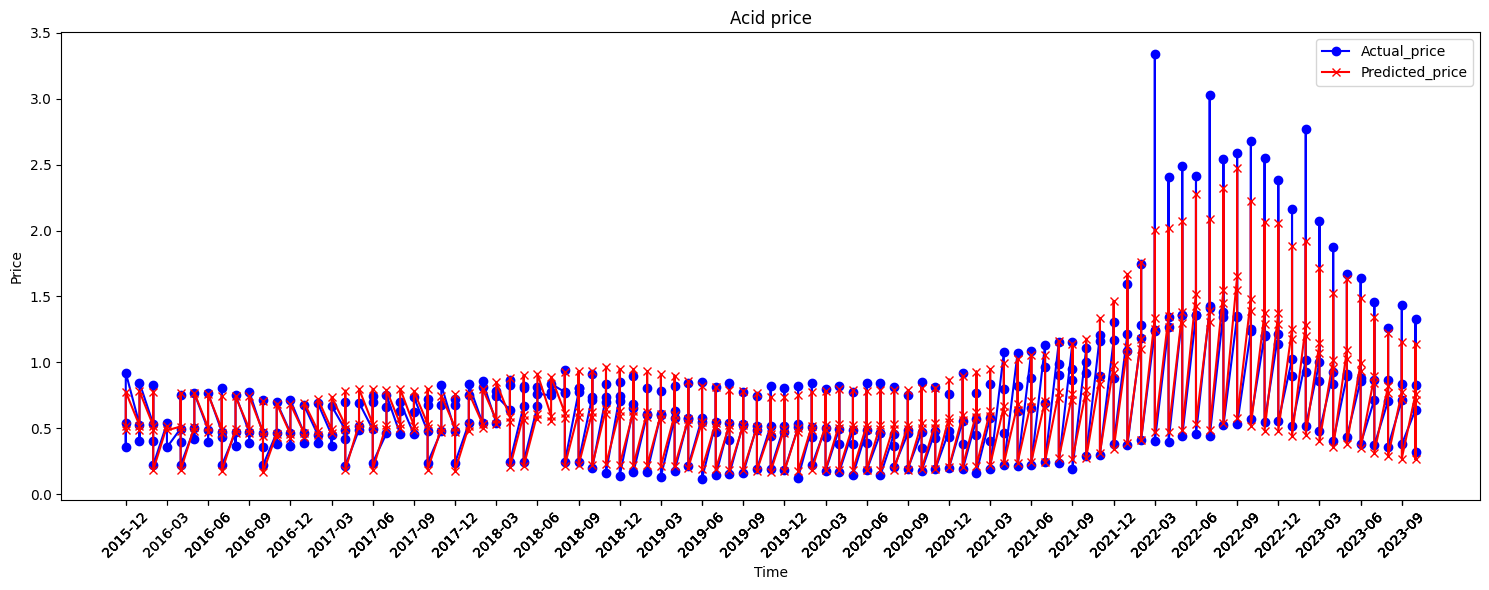

In [7]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Preprocessing 

# Import purchase data and price index data; rename columns

# gas_df = pre.get_Fred_data('PNGASEUUSDM',2015,2023)
# ammonia_df = pre.get_Fred_data('WPU0652013A',2015,2023)
# wheat_df = pre.get_Fred_data('PWHEAMTUSDM',2015,2023)

purchase = pd.read_csv("Dataset_Predicting_Price_Evolutions.csv",index_col=0)
purchase_data = purchase.loc[:,["POSTING DATE","Group Description","Key RM code","PRICE (EUR/kg)"]]
purchase_data.columns = ['date', 'group_description', 'key_rm_code', 'acid_price']

ele_data = pd.read_csv("ELECTRICITY.csv",index_col=0)
ele_data.columns = ['year', 'month', 'ele_price']

gas_data = pd.read_csv("PNGASEUUSDM.csv")
gas_data.columns = ['date', 'gas_price']

wheat_data = pd.read_csv("PWHEAMTUSDM.csv")
wheat_data.columns = ['date', 'wheat_price']

ammonia_data = pd.read_csv("WPU0652013A.csv")
ammonia_data.columns = ['date', 'ammonia_price']

# Filter purchase_data to contain only acid data

acid_data = purchase_data [purchase_data['group_description'] == 'acid'] # 3181 rows * 4 columns #

# Transform the timestamp into date, year, month, year_month

acid_data['date'] = pd.to_datetime(acid_data['date'])
acid_data['year'] = acid_data['date'].dt.year
acid_data['month'] = acid_data['date'].dt.month
acid_data['acid_ym'] = acid_data['year'].astype(str) + "-" + acid_data['month'].astype(str).str.zfill(2)
acid_data.sort_values(by = 'date', ascending = True, inplace = True)
acid_data.index = range(1, 3182)

ele_data['date'] = pd.to_datetime(ele_data[['year', 'month']].assign(day=1))
ele_data['year_month'] = ele_data['year'].astype(str) + "-" + ele_data['month'].astype(str).str.zfill(2)

gas_data['date'] = pd.to_datetime(gas_data['date'])
gas_data['year'] = gas_data['date'].dt.year
gas_data['month'] = gas_data['date'].dt.month
gas_data['year_month'] = gas_data['year'].astype(str) + "-" + gas_data['month'].astype(str).str.zfill(2)

wheat_data['date'] = pd.to_datetime(wheat_data['date'])
wheat_data['year'] = wheat_data['date'].dt.year
wheat_data['month'] = wheat_data['date'].dt.month
wheat_data['year_month'] = wheat_data['year'].astype(str) + "-" + wheat_data['month'].astype(str).str.zfill(2)

ammonia_data['date'] = pd.to_datetime(ammonia_data['date'])
ammonia_data['year'] = ammonia_data['date'].dt.year
ammonia_data['month'] = ammonia_data['date'].dt.month
ammonia_data['year_month'] = ammonia_data['year'].astype(str) + "-" + ammonia_data['month'].astype(str).str.zfill(2)

# Subset acid_data to contain data from 2015-12-01 to 2023-12-01

acid_2015 = acid_data [acid_data['date'] > '2015-12-01'] # 2589 rows x 7 columns #

# Calculate average price for 4 key_rm_code

key_rm_code_price = acid_2015.groupby(['key_rm_code'])['acid_price'].mean()
key_rm_code_count = acid_2015.groupby(['key_rm_code'])['acid_price'].count()
print (key_rm_code_price)
print (key_rm_code_count)

# Aggregate daily purchase data into monthly data in acid_2015

acid_month = acid_2015.groupby(['acid_ym','key_rm_code'])['acid_price'].mean()
acid_month = acid_month.to_frame()
acid_month = acid_month.reset_index() # 357 rows x 3 columns #
print (acid_month)

# Create category dummy variables in acid_month

cat_dum = pd.get_dummies(pd.DataFrame({'cat': ['01', '04', '06', '07']}),
                         drop_first = True,
                         dtype = int)
cat_dum.insert(0, 'key_rm_code', ['RM01/0001', 'RM01/0004', 'RM01/0006', 'RM01/0007'])
acid_cat = acid_month.merge(cat_dum, on = 'key_rm_code')
acid_dum = acid_cat.loc[:,["acid_ym","acid_price","cat_04","cat_06", "cat_07"]] # 357 rows x 5 columns #
# print (acid_dum)

# Add columns containing 12 months' data in price index dataframe

# substract non-duplicated year_month from acid_dum
acid_dum_dp = acid_dum.drop_duplicates(subset='acid_ym') # 95 rows x 5 columns #
acid_ym = acid_dum_dp['acid_ym']

# print(acid_data)
# print(ele_data)

# acid

# electricity

ele_dfs = {}
for i in range(12, 0, -1):
    if i >= 11:
        start_date = f"{2014}-{23-i}-01"
        end_date = f"{2022}-{23-i}-01"
    else :
        start_date = f"{2015}-{11-i}-01"
        end_date = f"{2023}-{11-i}-01"
    temp_df = ele_data[(ele_data['date'] > start_date) & (ele_data['date'] < end_date)]
    temp_df = temp_df.loc[:, ["ele_price", "year_month"]]
    temp_df.columns = [f'ele_price_{i}', f'ele_{i}_ym']
    acid_ym_df = acid_ym.to_frame(name='acid_ym').set_index(temp_df.index)
    ele_dfs[f'ele_{i}'] = pd.concat([temp_df, acid_ym_df], axis=1)

ele_merged = pd.DataFrame()
for key, df in ele_dfs.items():
    if ele_merged.empty:
        ele_merged = df
    else:
        ele_merged = pd.merge(ele_merged, df, on='acid_ym', how='outer')
ele_price = ele_merged.loc[:,["ele_price_12","acid_ym","ele_price_11","ele_price_10","ele_price_9","ele_price_8","ele_price_7",
                              "ele_price_6", "ele_price_5", "ele_price_4", "ele_price_3", "ele_price_2", "ele_price_1"]]

# gas

gas_dfs = {}
for i in range(12, 0, -1):
    if i >= 11:
        start_date = f"{2014}-{23-i}-01"
        end_date = f"{2022}-{23-i}-01"
    else :
        start_date = f"{2015}-{11-i}-01"
        end_date = f"{2023}-{11-i}-01"
    temp_df = gas_data[(gas_data['date'] > start_date) & (gas_data['date'] < end_date)]
    temp_df = temp_df.loc[:, ["gas_price", "year_month"]]
    temp_df.columns = [f'gas_price_{i}', f'gas_{i}_ym']
    acid_ym_df = acid_ym.to_frame(name='acid_ym').set_index(temp_df.index)
    gas_dfs[f'gas_{i}'] = pd.concat([temp_df, acid_ym_df], axis=1)

gas_merged = pd.DataFrame()
for key, df in gas_dfs.items():
    if gas_merged.empty:
        gas_merged = df
    else:
        gas_merged = pd.merge(gas_merged, df, on='acid_ym', how='outer')
gas_price = gas_merged.loc[:,["gas_price_12","acid_ym","gas_price_11","gas_price_10","gas_price_9","gas_price_8","gas_price_7",
                              "gas_price_6", "gas_price_5", "gas_price_4", "gas_price_3", "gas_price_2", "gas_price_1"]]

# wheat

wheat_dfs = {}
for i in range(12, 0, -1):
    if i >= 11:
        start_date = f"{2014}-{23-i}-01"
        end_date = f"{2022}-{23-i}-01"
    else :
        start_date = f"{2015}-{11-i}-01"
        end_date = f"{2023}-{11-i}-01"
    temp_df = wheat_data[(wheat_data['date'] > start_date) & (wheat_data['date'] < end_date)]
    temp_df = temp_df.loc[:, ["wheat_price", "year_month"]]
    temp_df.columns = [f'wheat_price_{i}', f'wheat_{i}_ym']
    acid_ym_df = acid_ym.to_frame(name='acid_ym').set_index(temp_df.index)
    wheat_dfs[f'wheat_{i}'] = pd.concat([temp_df, acid_ym_df], axis=1)

wheat_merged = pd.DataFrame()
for key, df in wheat_dfs.items():
    if wheat_merged.empty:
        wheat_merged = df
    else:
        wheat_merged = pd.merge(wheat_merged, df, on='acid_ym', how='outer')
wheat_price = wheat_merged.loc[:,["wheat_price_12","acid_ym","wheat_price_11","wheat_price_10","wheat_price_9","wheat_price_8","wheat_price_7",
                              "wheat_price_6", "wheat_price_5", "wheat_price_4", "wheat_price_3", "wheat_price_2", "wheat_price_1"]]

# ammonia

ammonia_dfs = {}
for i in range(12, 0, -1):
    if i >= 11:
        start_date = f"{2014}-{23-i}-01"
        end_date = f"{2022}-{23-i}-01"
    else :
        start_date = f"{2015}-{11-i}-01"
        end_date = f"{2023}-{11-i}-01"
    temp_df = ammonia_data[(ammonia_data['date'] > start_date) & (ammonia_data['date'] < end_date)]
    temp_df = temp_df.loc[:, ["ammonia_price", "year_month"]]
    temp_df.columns = [f'ammonia_price_{i}', f'ammonia_{i}_ym']
    acid_ym_df = acid_ym.to_frame(name='acid_ym').set_index(temp_df.index)
    ammonia_dfs[f'ammonia_{i}'] = pd.concat([temp_df, acid_ym_df], axis=1)

ammonia_merged = pd.DataFrame()
for key, df in ammonia_dfs.items():
    if ammonia_merged.empty:
        ammonia_merged = df
    else:
        ammonia_merged = pd.merge(ammonia_merged, df, on='acid_ym', how='outer')
ammonia_price = ammonia_merged.loc[:,["ammonia_price_12","acid_ym","ammonia_price_11","ammonia_price_10","ammonia_price_9","ammonia_price_8","ammonia_price_7",
                              "ammonia_price_6", "ammonia_price_5", "ammonia_price_4", "ammonia_price_3", "ammonia_price_2", "ammonia_price_1"]]

# Merge all dataframes

acid_df = acid_dum.merge(ele_price, on = 'acid_ym')
acid_df = acid_df.merge(gas_price, on = 'acid_ym')
acid_df = acid_df.merge(wheat_price, on = 'acid_ym')
acid_df = acid_df.merge(ammonia_price, on = 'acid_ym') 
# print (acid_df) # 357 rows x 53 columns #

## Modeling

# Creating feature and target arrays

feature_list = acid_df.drop(['acid_ym','acid_price'], axis = 1)
X = feature_list.values
y = acid_df['acid_price'].values

# Training set and test set

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 42)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
# print(np.mean(X), np.std(X))
# print(np.mean(X_train_scaled), np.std(X_test_scaled))

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))
# print(np.mean(y), np.std(y))
# print(np.mean(y_train_scaled), np.std(y_test_scaled))
# Is scaling of target variable necessary?

# Hyperparametter tuning and lasso

param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}
lasso = Lasso()
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)
random_search.fit(X_train_scaled, y_train_scaled)
print("Best alpha parameter:", random_search.best_params_['alpha'])
print("Best R-squared score:", round(random_search.best_score_, 3))
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
     print(f"{feature}: {round(coefficient,3)}")

# Draw plot 
    
X_scaled = scaler_X.transform(X)
predictions_scaled = random_search.best_estimator_.predict(X_scaled)
predictions = np.exp(scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)))

# (to confirm the number of rows in predictions)
# predictions_df = pd.DataFrame(predictions, columns=['predictions'])
# print (predictions_df)

acid_prediction = acid_month
print (acid_month)
acid_prediction['pred_price'] = predictions
# print (acid_prediction)
# acid_prediction.to_excel('/Users/hexiaomeng/Desktop/acid_prediction.xlsx',sheet_name = 'sheet1')

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))

plt.plot(acid_prediction['acid_ym'], acid_prediction['acid_price'],label='Actual_price', marker='o', color='blue')
plt.plot(acid_prediction['acid_ym'], acid_prediction['pred_price'],label='Predicted_price', marker='x', color='red')

filtered_acid = acid_prediction[acid_prediction['acid_ym'].str.endswith(('03', '06','09','12'))]
plt.xticks(ticks=filtered_acid['acid_ym'], labels=filtered_acid['acid_ym'])
plt.title('Acid price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # Plot seperately for each rm code

# acid_01 = acid_prediction [acid_prediction['key_rm_code'] == 'RM01/0001']
# acid_04 = acid_prediction [acid_prediction['key_rm_code'] == 'RM01/0004']
# acid_06 = acid_prediction [acid_prediction['key_rm_code'] == 'RM01/0006']
# acid_07 = acid_prediction [acid_prediction['key_rm_code'] == 'RM01/0007']

# # acid_01

# plt.figure(figsize=(15, 6))

# plt.plot(acid_01['acid_ym'], acid_01['acid_price'],label='Actual_price', marker='o', color='blue')
# plt.plot(acid_01['acid_ym'], acid_01['pred_price'],label='Predicted_price', marker='x', color='red')

# filtered_acid_01 = acid_01[acid_01['acid_ym'].str.endswith(('06','12'))]
# plt.xticks(ticks=filtered_acid_01['acid_ym'], labels=filtered_acid_01['acid_ym'])
# plt.title('Acid_01 price')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # acid_04

# plt.figure(figsize=(15, 6))

# plt.plot(acid_04['acid_ym'], acid_04['acid_price'],label='Actual_price', marker='o', color='blue')
# plt.plot(acid_04['acid_ym'], acid_04['pred_price'],label='Predicted_price', marker='x', color='red')

# filtered_acid_04 = acid_04[acid_04['acid_ym'].str.endswith(('06','12'))]
# plt.xticks(ticks=filtered_acid_04['acid_ym'], labels=filtered_acid_04['acid_ym'])
# plt.title('Acid_04 price')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # acid_06

# plt.figure(figsize=(15, 6))

# plt.plot(acid_06['acid_ym'], acid_06['acid_price'],label='Actual_price', marker='o', color='blue')
# plt.plot(acid_06['acid_ym'], acid_06['pred_price'],label='Predicted_price', marker='x', color='red')

# filtered_acid_06 = acid_06[acid_06['acid_ym'].str.endswith(('06','12'))]
# plt.xticks(ticks=filtered_acid_06['acid_ym'], labels=filtered_acid_06['acid_ym'])
# plt.title('Acid_06 price')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # acid_07

# plt.figure(figsize=(15, 6))

# plt.plot(acid_07['acid_ym'], acid_07['acid_price'],label='Actual_price', marker='o', color='blue')
# plt.plot(acid_07['acid_ym'], acid_07['pred_price'],label='Predicted_price', marker='x', color='red')

# filtered_acid_07 = acid_07[acid_07['acid_ym'].str.endswith(('06','12'))]
# plt.xticks(ticks=filtered_acid_07['acid_ym'], labels=filtered_acid_07['acid_ym'])
# plt.title('Acid_07 price')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
